# SML regressor comparison

In [36]:
import pandas as pd
from river.stream import iter_pandas
from river.metrics.base import Metrics
from river.metrics import MAE,MAPE,MSE,RMSE,base
from river.evaluate import progressive_val_score
from river.preprocessing import StandardScaler
from river.drift import ADWIN
import numpy as np
import matplotlib.pyplot as plt

## Dataset generation

Due dataset, uno che genera i dati della funzione del prezzo reale, l'altro con uno shift che servirà ad analizzare la capacità di adattamento.

In [37]:
# import numpy as np

# # Set parameters for the market function
# a = 100.0
# b = 0.5

# def market_function(prod1, prod2):
#     # Deterministic market function with non-negativity
#     return max(0, a - b * (prod1 + prod2))

# # Generate random values for Production1 and Production2
# np.random.seed(42)  # For reproducibility
# production1 = np.random.randint(0, 101, 1000)
# production2 = np.random.randint(0, 101, 1000)

# # Compute Market_price
# market_price = [market_function(p1, p2) for p1, p2 in zip(production1, production2)]

# # Create DataFrame
# df = pd.DataFrame({
#     'Market_price': market_price,
#     'Production1': production1,
#     'Production2': production2
# })

# # Save to CSV
# df.to_csv("market_data.csv", index=False)

In [ ]:
# import numpy as np

# # Set parameters for the market function
# a = 100.0
# b = 0.5

# def market_function(prod1, prod2):
#     # Deterministic market function with non-negativity
#     return max(0, a - b * (prod1 + prod2) + 200)

# # Generate random values for Production1 and Production2
# np.random.seed(42)  # For reproducibility
# production1 = np.random.randint(0, 101, 1000)
# production2 = np.random.randint(0, 101, 1000)

# # Compute Market_price
# market_price = [market_function(p1, p2) for p1, p2 in zip(production1, production2)]

# # Create DataFrame
# df = pd.DataFrame({
#     'Market_price': market_price,
#     'Production1': production1,
#     'Production2': production2
# })

# # Save to CSV
# df.to_csv("market_data_drift.csv", index=False)

In [56]:
data = pd.read_csv("market_data.csv")
features = data.columns[1:]

In [61]:
data_drift = pd.read_csv("market_data_drift.csv")
features_drift = data_drift.columns[1:]

## Regressors

- Linear regression
- KNN regression
- Hoeffding Tree regression
- Hoeffding Adaptive Tree regression
- Adaptive Random Forest regression
- SRP regression

In [41]:
# Creating online learners
# 1. Linear Regression
from river.linear_model import LinearRegression

LinearReg = (StandardScaler() |
        LinearRegression(intercept_lr=.1))
LinearReg_mse = Metrics(metrics=[MSE()])
stream = iter_pandas(X=data[features], y=data['Market_price'])

progressive_val_score(dataset=stream,
                      model=LinearReg,
                      metric=LinearReg_mse,
                      print_every=100)

[100] MSE: 185.583199
[200] MSE: 94.142366
[300] MSE: 62.778325
[400] MSE: 47.10314
[500] MSE: 37.688282
[600] MSE: 31.408567
[700] MSE: 26.922107
[800] MSE: 23.558162
[900] MSE: 20.941124
[1,000] MSE: 18.847308


MSE: 18.847308

In [42]:
# 2. KNN Regression
from river.neighbors import KNNRegressor,SWINN
import functools
from river import utils

l1_dist = functools.partial(utils.math.minkowski_distance, p=1)
KNN = (StandardScaler() |
        KNNRegressor(n_neighbors=5, engine=SWINN(dist_func=l1_dist,seed=42,maxlen=1000)))
KNN_mse = Metrics(metrics=[MSE()])
stream = iter_pandas(X=data[features], y=data['Market_price'])

progressive_val_score(dataset=stream,
                      model=KNN,
                      metric=KNN_mse,
                      print_every=100)

[100] MSE: 89.016394
[200] MSE: 48.473497
[300] MSE: 33.641765
[400] MSE: 25.956799
[500] MSE: 21.122999
[600] MSE: 17.811216
[700] MSE: 15.450985
[800] MSE: 13.658649
[900] MSE: 12.251099
[1,000] MSE: 11.148989


MSE: 11.148989

In [43]:
# 3. Hoeffding Tree
from river.tree import HoeffdingTreeRegressor

HT = (StandardScaler() |
        HoeffdingTreeRegressor(
            grace_period=100,
            leaf_prediction='adaptive',
            model_selector_decay=0.9,            
        ))
HT_mse = Metrics(metrics=[MSE()])
stream = iter_pandas(X=data[features], y=data['Market_price'])

progressive_val_score(dataset=stream, 
                      model=HT, 
                      metric=HT_mse, 
                      print_every=100)

[100] MSE: 346.243823
[200] MSE: 181.82307
[300] MSE: 121.288179
[400] MSE: 90.992238
[500] MSE: 72.803925
[600] MSE: 60.675819
[700] MSE: 52.010685
[800] MSE: 45.510978
[900] MSE: 40.457499
[1,000] MSE: 36.412907


MSE: 36.412907

In [44]:
# 4. Hoeffding Adaptive Tree
from river.tree import HoeffdingAdaptiveTreeRegressor

HAT = (StandardScaler() |
        HoeffdingAdaptiveTreeRegressor(
            grace_period=100,
            leaf_prediction='adaptive',
            model_selector_decay=0.9,
            seed=1,            
        ))
HAT_mse = Metrics(metrics=[MSE()])
stream = iter_pandas(X=data[features], y=data['Market_price'])

progressive_val_score(dataset=stream, 
                      model=HAT, 
                      metric=HAT_mse, 
                      print_every=100)

[100] MSE: 289.915159
[200] MSE: 147.445879
[300] MSE: 98.350859
[400] MSE: 73.802759
[500] MSE: 69.818122
[600] MSE: 58.285068
[700] MSE: 49.984667
[800] MSE: 43.741804
[900] MSE: 38.886143
[1,000] MSE: 34.999334


MSE: 34.999334

In [45]:
# 5. Adaptive Random Forest
from river.forest import ARFRegressor

ARF = (StandardScaler() |
        ARFRegressor(
            n_models=10,
            seed=1,
            model_selector_decay=0.9,           
            leaf_prediction='adaptive'
        ))
ARF_mse = Metrics(metrics=[MSE()])
stream = iter_pandas(X=data[features], y=data['Market_price'])

progressive_val_score(dataset=stream, 
                      model=ARF, 
                      metric=ARF_mse, 
                      print_every=100)

[100] MSE: 121.534169
[200] MSE: 62.305882
[300] MSE: 41.82039
[400] MSE: 31.493062
[500] MSE: 25.247776
[600] MSE: 21.078248
[700] MSE: 18.089508
[800] MSE: 15.846511
[900] MSE: 14.099743
[1,000] MSE: 12.700969


MSE: 12.700969

In [46]:
# 6. SRP
from river.ensemble import SRPRegressor
from river.tree import HoeffdingTreeRegressor

SRP = (StandardScaler() |
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001),
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=100,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,                
            )            
        ))
SRP_mse = Metrics(metrics=[MSE()])
stream = iter_pandas(X=data[features], y=data['Market_price'])

progressive_val_score(dataset=stream, 
                      model=SRP, 
                      metric=SRP_mse, 
                      print_every=100)


[100] MSE: 91.98652
[200] MSE: 46.236635
[300] MSE: 30.89243
[400] MSE: 23.199824
[500] MSE: 18.579789
[600] MSE: 15.491267
[700] MSE: 13.283093
[800] MSE: 11.626202
[900] MSE: 10.339916
[1,000] MSE: 9.309563


MSE: 9.309563

## SRP analysis
Propongo due analisi: la prima per vedere che dopo uno span sufficiente di tempo l'approssimazione è buona, la seconda per controllare che a valle di un cambio della funzione generatrice il modello riesca ad adattarsi.

> Convergence analysis

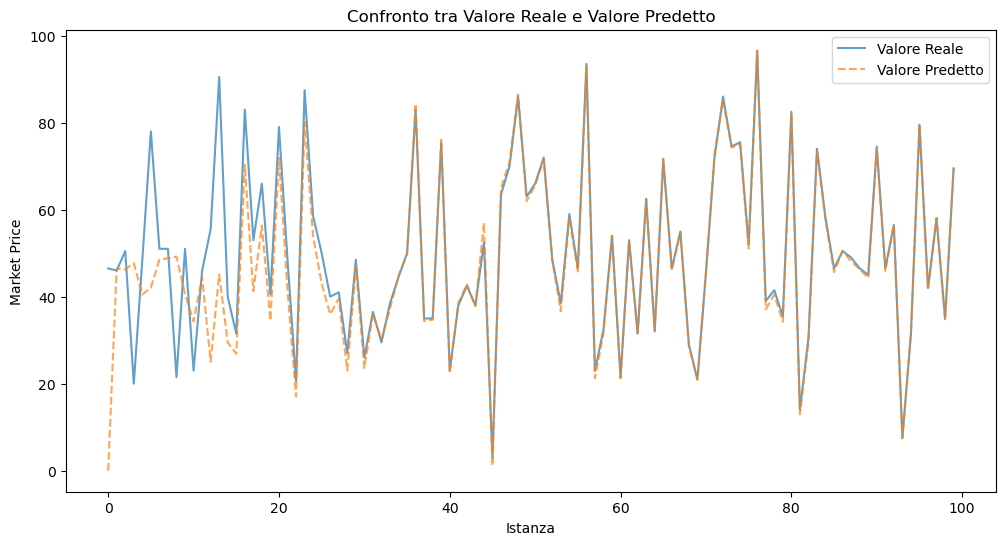

In [47]:
# SRP sembra il migliore
from river.ensemble import SRPRegressor
from river.tree import HoeffdingTreeRegressor

SRP = (StandardScaler() |
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001),
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=100,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,                
            )            
        ))
SRP_mse = Metrics(metrics=[MAE()])
stream = iter_pandas(X=data[features], y=data['Market_price'])

# Liste per salvare i valori reali e predetti
y_true = []
y_pred = []

# Itera nel dataset e raccoglie i dati per il grafico
for i, (x, y) in enumerate(stream):
    y_hat = SRP.predict_one(x)  # Predizione del modello
    y_true.append(y)
    y_pred.append(y_hat)
    
    SRP.learn_one(x, y)  # Addestramento online

# Plot dei risultati
plt.figure(figsize=(12, 6))
plt.plot(y_true[:100], label="Valore Reale", linestyle='solid', alpha=0.7)
plt.plot(y_pred[:100], label="Valore Predetto", linestyle='dashed', alpha=0.7)
plt.xlabel("Istanza")
plt.ylabel("Market Price")
plt.title("Confronto tra Valore Reale e Valore Predetto")
plt.legend()
plt.show()



> Drift analysis:

In [62]:
# Seleziona le prime 50 righe di entrambi i dataset
data_50 = data.head(100)
data_drift_50 = data_drift.head(100)

# Stack verticale (concatenazione)
stacked_df = pd.concat([data_50, data_drift_50], axis=0, ignore_index=True)

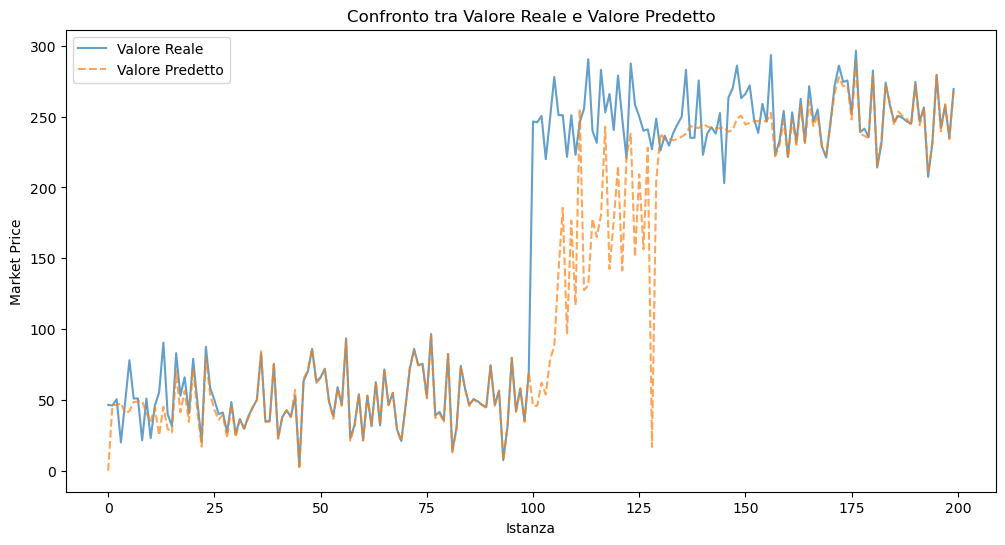

In [63]:
# SRP sembra il migliore
from river.ensemble import SRPRegressor
from river.tree import HoeffdingTreeRegressor
from river.preprocessing import AdaptiveStandardScaler

SRP = (StandardScaler() | # provare adaptive 
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001), # abbassarlo per reagire + velocemente ai cambiamenti
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=100,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,                
            )            
        ))
SRP_mse = Metrics(metrics=[MAE()])
stream = iter_pandas(X=stacked_df[features], y=stacked_df['Market_price'])

# Liste per salvare i valori reali e predetti
y_true = []
y_pred = []

# Itera nel dataset e raccoglie i dati per il grafico
for i, (x, y) in enumerate(stream):
    y_hat = SRP.predict_one(x)  # Predizione del modello
    y_true.append(y)
    y_pred.append(y_hat)
    
    SRP.learn_one(x, y)  # Addestramento online

# Plot dei risultati
plt.figure(figsize=(12, 6))
plt.plot(y_true, label="Valore Reale", linestyle='solid', alpha=0.7)
plt.plot(y_pred, label="Valore Predetto", linestyle='dashed', alpha=0.7)
plt.xlabel("Istanza")
plt.ylabel("Market Price")
plt.title("Confronto tra Valore Reale e Valore Predetto")
plt.legend()
plt.show()